# Python assignment: Bias of invalid IV estimates

|Name        |SNR    |ANR   |
| :--:       | :--:  | :--: |
|Emilie Facon|2034446|782549|

---

# Abstract


In this project, I explore the bias of instrumental variable (IV) estimates when the usual assumptions are violated. I look at the use of instruments in the context of an omitted variable bias, in the simple case with one endogenous variable and one instrument, with homogeneous treatment effects. I approximate the sampling distribution of the IV and ordinary least squares (OLS) estimators under different conditions using Monte Carlo simulations.

Firstly, when both the exogeneity and relevance conditions are safistisfied, I show that the IV estimator is consistent while the OLS estimator is not. 

Secondly, when exoegeneity fails, the bias of the IV estimator depends on the sign of the correlation between: (i) the dependent and the omitted variable, (ii) the instrument and the endogenous variable, and (iii) the instrument and the omitted variable.

Thirdly, when relevance fails, the IV estimator is biased and inconsistent, and the median of the IV estimator approaches that of OLS.

# Contents

1. [Research question](#Research-question)
* [Motivation](#Motivation)
* [Methods](#Methods)
* [Preview of the answers](#Preview-of-the-answers)
* [Defining the OLS and IV estimators](#Defining-the-OLS-and-IV-estimators)
* [Main assumptions](#Main-assumptions)
* [Analysis](#Analysis)
    1. [Case 1: Both exogeneity and relevance are satisfied](#Case-1:-Both-exogeneity-and-relevance-are-satisfied)
    2. [Case 2: Exogeneity fails](#Case-2:-Exogeneity-fails)
    3. [Case 3: Relevance fails](#Case-3:-Relevance-fails)
* [Discussion and conclusion](#Discussion-and-conclusion)

In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

# Research question

What happens to instrumental variable estimates when its assumptions are not satisfied? In which direction are they biased and inconsistent?

# Motivation

### A short introduction to instrumental variables estimation

The method of instrumental variables (IV) is a powerful way of establishing causal estimates in the presence of simultaneity,  measurement error in the independent variable, or omitted variables ([Angrist and Krueger, 2001](http://www.aeaweb.org/articles?id=10.1257/jep.15.4.69)). In this project, I focus on the use of instrumental variables in the context of omitted variables. 

The video below explains how instrumental variables work using the example of the Vietnam era draft lottery ([Angrist, 1990](https://www.jstor.org/stable/2006669)). 
Let us assume that a researcher is interested in the impact of military service on lifetime earnings. He cannot simply regress military service (as a dummy variable) on earnings, as self-selection is likely to be an issue: some people might have unobserved characteristics that make them more likely both to enlist in the military and have a lower income. This means that OLS estimates are biased and inconsistent. 

To get consistent estimates, we need an exogenous source of random variation in the independent variable. Here, the draft lottery is a good candidate, as numbers are randomly assigned to individuals, and are therefore uncorrelated with unobservable characteristics. 
Some people were chosen but did not serve in the military (e.g. objectors - these are called never-takers), some were not chosen but still served (e.g. volunteers - they are the always-takers). 
However, most people ended up serving in the war when they were drafted, but not when they were not drafted - these are known as the compliers. 
When we use the draft lottery as an instrument for military service, we use the randomness brought by the lottery to estimate the causal effect of military service on lifetime earnings. 
More precisely, we estimate the Local Average Treatment Effect (LATE), which is the average causal effect for the compliers.

For a detailed explanation of IV estimation, see Chapter 15 of [Wooldridge (2013)](https://www.cengage.com/c/introductory-econometrics-a-modern-approach-5e-wooldridge/9781111531041PF/), Chapter 3 of [Angrist and Pischke (2014)](https://www.masteringmetrics.com/), Chapter 4 of [Angrist and Pischke (2008)](https://www.mostlyharmlesseconometrics.com/) and Sections 4.8 and 4.9 of [Cameron and Trivedi (2005)](https://www.cambridge.org/9780521848053).

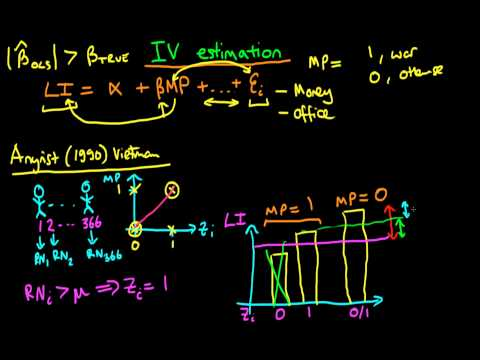

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('NLgB2WGGKUw')

### The importance of instrumental variables in the economics literature

Instrumental variables estimation has become a widespread method in economics, epidemiology ([Greenland, 2000](https://doi.org/10.1093/ije/29.4.722)) and social sciences.
For example, [Angrist and Krueger (1991)](http://www.jstor.org/stable/2937954) use quarter of birth as an instrument for years of schooling to estimate the causal effect of education on wages.
[Acemoglu, Jonhson and Robinson (2001)](https://www.aeaweb.org/articles?id=10.1257/aer.91.5.1369) use differences in European settler mortality rates as an instrument for current institutions, to estimate the causal impact of institutions on income per capita.
In political science, [Colantone and Stanig (2018)](https://onlinelibrary.wiley.com/doi/abs/10.1111/ajps.12358) focus on European countries, and use Chinese imports to the United States as an instrument for imports to Europe, to assess the impact of a trade shock on the vote share of nationalist parties.
These are only a few examples of how instrumental variables have been previously used in the literature. Given the popularity of this method, it is important to understand its strengths and weaknesses.

IV estimates are only valid when the underlying assumptions are satisfied. When they are violated, the estimates are biased and inconsistent, but it is not always intuitive to say in which direction the bias goes. 
This project aims to clarify these issues, and provide a more intuitive understanding of the IV method, which might be useful to the next generation of students taking [Econometrics 1](https://catalogus.tilburguniversity.edu/osiris_student_tiuprd/OnderwijsCatalogusSelect.do?selectie=cursus&taal=en&collegejaar=2018&cursus=310153-M-3).

# Methods

I use Monte Carlo simulations to approximate the sampling distribution of OLS and IV estimators under different conditions, under different sets of assumptions.

The advantage of using Monte Carlo simulations is that they allow to compare the IV estimates obtained to the actual parameters in the data generating process (which is known).

# Preview of the answers

In this project, I focus on the key assumptions of instrument exogeneity and instrument relevance, and look at the case where there is an omitted variable correlated with the variable of interest.

1. When both exogeneity and relevance are satisfied, the IV estimator is consistent, while the OLS estimator suffers from omitted variable bias.

2. When exogeneity is violated, the IV estimator is no longer consistent. The direction of the bias depends on: (i) the correlation between the dependent and the omitted variable, (ii) the correlation between the instrument and the endogenous variable, and (iii) the correlation between the instrument and the omitted variable.

3. When relevance is violated, the IV estimator is no longer consistent, and its median approaches that of OLS.

# Defining the OLS and IV estimators

In this section, I define the OLS and IV estimators, and write functions to compute them.

#### Linear regression model

Let us assume a standard linear regression model. In matrix notation

$$ \boldsymbol{y} = \boldsymbol{X \beta} + \boldsymbol{\epsilon} $$

where $\boldsymbol{y}$ is a $N \times 1$ vector of dependent variables, 
$\boldsymbol{X}$ is an $N \times K$ regression matrix,
$\boldsymbol{\beta}$ is a $K \times 1$ parameter vector, 
and $\boldsymbol{\epsilon}$ is an $N \times 1$ error vector ([Cameron and Trivedi, 2005, p. 71](https://www.cambridge.org/9780521848053)). 

#### OLS estimator

The formula for the OLS estimator is

$$\hat{\boldsymbol{\beta}}_{OLS} = (\boldsymbol{X'X})^{-1}\boldsymbol{X'y}$$

The OLS estimator is unbiased and consistent when its assumptions are satisfied, in particular when all components of $\boldsymbol{X}$ are exogenous (see [Cameron and Trivedi, 2005, p. 76](https://www.cambridge.org/9780521848053) for the full set of OLS assumptions).

In [3]:
# Defining the OLS estimator

def ols_reg(y, X, constant=True):
    
    y = np.matrix(y).transpose() # N x 1
        # np.matrix() returns a 1 x N vector
        # Need to transpose y to get a N x 1 vector instead
        # Same issue for X and Z
        
    X = np.matrix(X).transpose() # N x K
    
    if constant == True:
        N = np.shape(X)[0] # Number of rows
        X = np.concatenate( (np.ones((N, 1)), X), axis = 1) # Add a column of ones for the constant
        
    elif constant == False:
        pass
        
    beta_ols = np.linalg.inv(X.transpose()*X) * X.transpose() * y # Returns a K x 1 matrix    
    
    return(beta_ols) 

#### IV estimator 

The formula for the IV estimator is 

$$\hat{\boldsymbol{\beta}}_{IV} = (\boldsymbol{Z'X})^{-1}\boldsymbol{Z'y}$$

when the model is just-identified such that $r = q$, where $r$ is the number of instruments and $q$ is the number of endogenous variables ([Cameron and Trivedi, 2005, p. 100](https://www.cambridge.org/9780521848053)). 

$\boldsymbol{Z}$ is an $N \times K$ matrix containing the instruments and the exogenous regressors, and $\boldsymbol{X}$ is a $N \times K$ matrix containing both endogenous and exogenous regressors.

Here, I focus on the case when $r = q = 1$. In this case, the two-stage-least-squares (2SLS) is equivalent to the IV estimator.

In [4]:
# Defining the IV estimator

def iv_reg(y, X, Z, constant=True):
    
    y = np.matrix(y).transpose()
    X = np.matrix(X).transpose()
    Z = np.matrix(Z).transpose()

    if constant == True:
        N = np.shape(X)[0]
        X = np.concatenate( (np.ones((N, 1)), X), axis = 1)
        Z = np.concatenate( (np.ones((N, 1)), Z), axis = 1)
        
    elif constant == False:
        pass
    
    beta_iv = np.linalg.inv(Z.transpose()*X) * Z.transpose() * y    
    return(beta_iv)

# Main assumptions

### Data generating process 


#### Model

To provide better intuition, I use the example of the relationship between education and wages, with ability as an unobservable omitted variable. I use a simple linear model, and focus on the case of homogeneous treatment effect in order to simplify the analysis. The data generating process is

$$wage = \beta_0 + \beta_1 education + \beta_2 ability + \epsilon$$

where $\beta_0$,  $\beta_1$ and $\beta_2$ are the same for all individuals, $education$ and $ability$ are given for each individual, and $\epsilon$ is an independent error term of mean zero.

In [5]:
# Defining the data generating process for wages

def gen_wage(educ, abil, epsilon):
    wage = beta_0 + beta_1 * educ + beta_2 * abil + epsilon
    return(wage)

I arbitrarily set the parameters to $\beta_0 = 10$, $\beta_1 = 3$, $\beta_2 = 5$. These parameter values can then be compared to the OLS and IV estimates, in order to assess the biasedness and consistency of the estimators.

In [6]:
# Setting the parameters

beta_0 = 10
beta_1 = 3
beta_2 = 5

#### Observed and unobserved variables

Now, let us assume that an researcher wants to $\beta_1$, the causal effect of an additional year of schooling on wages. However, she cannot observe $ability$. Thus, she can only run the  regression

$$wage = \theta_0 + \theta_1 education + u$$

where $u = \beta_2 ability + \epsilon$ is unobserved.

#### Generating the data

Let us consider a variable $z$ which is a potential candidate for an instrumental variable.

To simplify the analysis, I assume that $education$, $ability$, the instrument $z$ and the error $\epsilon$ follow a multivariate normal distribution with mean 0 and covariance matrix $\boldsymbol{\Omega}$. 
I choose covariance matrices with only 1s in the diagonal, which means that variables have a variance of 1. 
Thus, these are standardised variables.

In [7]:
# Generating the data

def gen_data(mean, Ω, N):
    
    global educ, abil, z, epsilon, wage, u # Generate global variables
    
    educ, abil, z, epsilon = np.random.multivariate_normal(mean, Ω, N).T 
        # Draw from multivariate normal distribution
        # Need to transpose to get (N x 1) vectors
    
    wage = gen_wage(educ, abil, epsilon)
    
    u = beta_2 * abil + epsilon

### Instrumental variable assumptions

#### Theory

In this section, I cover the conditions under which an instrument $z$ is valid and leads to consistent estimates (in the case of homogeneous treatment effects).
In addition to the usual assumptions of linearity in parameters, random sampling, no perfect collinearity ([Wooldridge, 2013, p. 551-552](https://www.cengage.com/c/introductory-econometrics-a-modern-approach-5e-wooldridge/9781111531041PF/)), the key assumptions for identification are instrument exogeneity and relevance ([Wooldridge, 2013, p. 514](https://www.cengage.com/c/introductory-econometrics-a-modern-approach-5e-wooldridge/9781111531041PF/)). 

##### 1. Instrument exogeneity: $Cov(z, u) = 0$

Here, given $u = \beta_2 ability + \epsilon$, this implies 

$$Cov(z, \beta_2 ability + \epsilon) = \beta_2 Cov(z, ability) + Cov(z, \epsilon) = 0$$

However, we know that $Cov(z, \epsilon) = 0$ given $\epsilon$ is an error term independent from the other variables. 

Therefore, we need $Cov(z, ability) = 0$ for exogeneity to hold. The instrument must be uncorrelated with ability.

##### 2. Instrument relevance: $Cov(z, x) \neq 0$

Here, the independent variable is education, so we need $Cov(z,education) \neq 0$. The instrument must be correlated with education.

When the IV assumptions are safisfied, the IV estimator is biased (in finite samples) but consistent. 
In this project, I use a sample size $N=1000$, such that we can rely on the asymptotic properties of the IV estimator. 
When the IV assumptions are violated, the IV estimator is both biased and inconsistent, as I will show in the next section.

# Analysis


### Case 1: Both exogeneity and relevance are satisfied


First, let us consider the case where the instrument is valid and satisfies both the relevance and exogeneity conditions. 

#### Covariance matrix

As said earlier, the covariance matrix of the multivariate normal distribution of $(education, ability, z, \epsilon)$ has only 1s in the diagonal.

$\epsilon$ is independent from all other variables, so the last row and last column has only 0s (except from 1 in the diagonal).

Thus, the covariance matrix of the multivariate normal distribution becomes

\begin{equation*}
\mathbf{\Omega} =  \begin{bmatrix}
1 & Cov(educ, abil) & Cov(educ, z) & 0 \\
Cov(abil, educ) & 1 & Cov(abil, z) & 0 \\
Cov(z, educ) & Cov(z, abil) & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

In [8]:
# Generating a covariance matrix for (educ, abil, z, epsilon)

def gen_cov_matrix(cov_z_abil, cov_z_educ, cov_educ_abil):
    return [[1, cov_educ_abil, cov_z_educ, 0], \
            [cov_educ_abil, 1, cov_z_abil, 0], \
            [cov_z_educ, cov_z_abil, 1, 0], \
            [0, 0, 0, 1]]


The exogeneity condition is $Cov(z, ability) = 0$

Moreover, the relevance condition is $Cov(z, education) \neq 0$. Here, I set $Cov(z, education) = 0.5$.

Finally, I set $Cov(education, ability)=0.7$. 
Note that if $Cov(education, ability)=0$, then there would not be an omitted variable problem, and the OLS estimator would be unbiased and consistent. 
When $Cov(education, ability) \neq 0$, the OLS estimates are no longer consistent, which is why we need to use IV estimation.

Thus, the covariance matrix is

\begin{equation*}
\mathbf{\Omega} =  \begin{bmatrix}
1 & 0.7 & 0.5 & 0 \\
0.7 & 1 & 0 & 0 \\
0.5 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

In [9]:
# Set the mean, covariance matrix and number of observations

mean = [0, 0, 0, 0]

cov_valid = gen_cov_matrix(cov_z_abil = 0, # Exogeneity satisfied
                        cov_z_educ= 0.5, # Relevance satisfied
                        cov_educ_abil = 0.7)
print(np.matrix(cov_valid))

N = 1000 # Number of observations

[[1.  0.7 0.5 0. ]
 [0.7 1.  0.  0. ]
 [0.5 0.  1.  0. ]
 [0.  0.  0.  1. ]]


I now generate the data and provide a visual illustration of the distribution of $wage$, $education$, $z$ and $u$, where $u = \beta_2 ability + \epsilon$.

<Figure size 432x288 with 0 Axes>

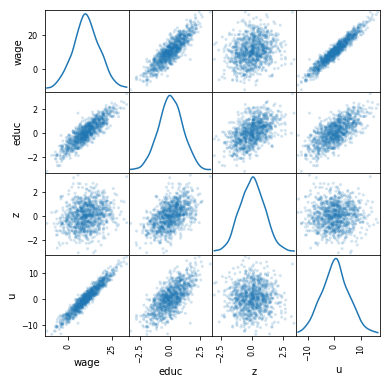

In [10]:
# Generate the data

np.random.seed(0)
gen_data(mean, cov_valid, N)

# Explore the data: scatter matrix

df = pd.DataFrame([wage, educ, z, u]).transpose()
df.columns = ['wage', 'educ', 'z', 'u']

plt.clf()
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

We can see from the scatter plots below that $z$ is indeed correlated with $education$, but not with the unobserved error term $u$.

#### Monte Carlo simulations

The next cell contains a function that runs Monte Carlo simulations.

It takes as inputs:
* the mean and covariance matrix $\Omega$ of the multivariate normal distribution of $(wage, education, z, \epsilon)$
* $N$: number of observations
* $B$: number of simulations
* `reg_type`: whether only IV results or both IV and OLS are required

For each simulation, I draw a sample from the multivariate normal distribution, calculate the $wage$ according to the data generating process, compute the IV (and OLS) estimates and store them. The function does this $B$ times in total, and returns the vector(s) of IV (and OLS) estimates.

In [11]:
# Monte Carlo simulations: OLS and IV

def run_simulations(mean, cov, N, B, reg_type):
    
    np.random.seed(0)
    
    if reg_type == "iv and ols":
        
        iv_results = []
        ols_results = []

        for i in range(0, B):

            educ, abil, z, epsilon = np.random.multivariate_normal(mean, cov, N).T
            wage = gen_wage(educ, abil, epsilon)

            beta_iv = iv_reg(y=wage, X=educ, Z=z)
            beta_iv = beta_iv.item(1) # Only store coefficient beta_1
            iv_results.append(beta_iv)

            beta_ols = ols_reg(y=wage, X=educ)
            beta_ols = beta_ols.item(1) # Only store coefficient beta_1
            ols_results.append(beta_ols)

        return(iv_results, ols_results)
    
    elif reg_type == "iv":
        
        iv_results = []

        for i in range(0, B):

            educ, abil, z, epsilon = np.random.multivariate_normal(mean, cov, N).T
            wage = gen_wage(educ, abil, epsilon)

            beta_iv = iv_reg(y=wage, X=educ, Z=z)
            beta_iv = beta_iv.item(1) # Only store coefficient beta_1
            iv_results.append(beta_iv)

        return(iv_results)       
    
    else: 
        
        print("Error")

I call the function previously defined and run the simulations $B=10000$ times. 

In [12]:
# Run the simulations

B = 10000 # Number of simulations
N = 1000 # Number of observations

iv_results, ols_results = run_simulations(mean, cov_valid, N, B, "iv and ols")

print("Mean of OLS estimates:", round(np.mean(ols_results), 2))
print("Mean of IV estimates:", round(np.mean(iv_results), 2))
print("True parameter value:", beta_1)

Mean of OLS estimates: 6.5
Mean of IV estimates: 2.98
True parameter value: 3


We can see that the mean of the IV estimates is much closer to the true parameter value than the OLS estimates, meaning that the bias of the IV estimator is smaller than that of the OLS estimator.

Finally, I plot the distribution of OLS and IV estimates. 

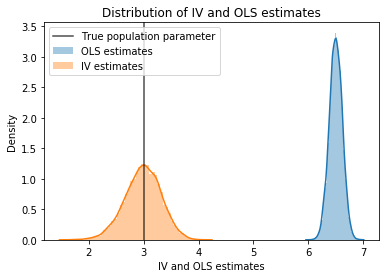

In [13]:
# Plot OLS and IV distributions

plt.clf()

sns.distplot(ols_results, hist=True, kde=True, label='OLS estimates')
sns.distplot(iv_results, hist=True, kde=True, label='IV estimates')
plt.axvline(x=beta_1, color='black', alpha = 0.7, label='True population parameter')
plt.legend()

plt.title("Distribution of IV and OLS estimates")
plt.xlabel("IV and OLS estimates")
plt.ylabel("Density")

plt.show()

# Store valid IV results 

iv_valid = iv_results

The figure shows that the IV estimates are centered around the true population value, whereas the OLS estimates are much higher and centered around 6.5.

Thus, when the IV assumptions are satisfied and in the presence of an omitted variable, the IV estimates are consistent, whereas OLS estimates are not.

## Case 2: Exogeneity fails


Let us now consider the case where the relevance condition is satisfied, but exogeneity fails.

#### Covariance matrix

The exogeneity condition is $Cov(z, ability) = 0$. Here, I set $Cov(z, ability) = 0.1$. I choose a relatively small number to show that estimates are inconsistent even when the correlation between the instrument and the omitted variable is small.

The relevance condition remains satisfied, so I keep $Cov(z, education) = 0.5$. I also keep the assumption that $Cov(education, ability)=0.7$. 

The covariance matrix becomes

\begin{equation*}
\mathbf{\Omega} =  \begin{bmatrix}
1 & 0.7 & 0.5 & 0 \\
0.7 & 1 & \boldsymbol{0.1} & 0 \\
0.5 & \boldsymbol{0.1} & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

where the values in bold are the ones that have changed compared to the first case.

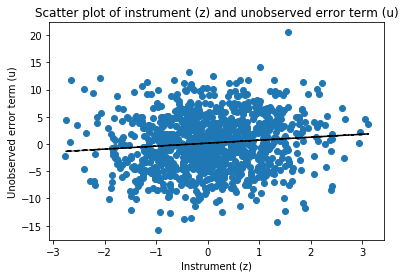

In [14]:
# Set the parameters

mean = [0, 0, 0, 0]

cov_not_exog = gen_cov_matrix(cov_z_abil = 0.1, # Exogeneity violated
                        cov_z_educ= 0.5, # Relevance satisfied
                        cov_educ_abil = 0.7)

N = 1000 

# Generate the data

np.random.seed(0)
gen_data(mean, cov_not_exog, N)

# Relationship between z and u: exogeneity fails

plt.clf()
plt.scatter(z, u)
plt.title("Scatter plot of instrument (z) and unobserved error term (u)")
plt.xlabel("Instrument (z)")
plt.ylabel("Unobserved error term (u)")

trend_line = np.polyfit(z, u, 1)
p = np.poly1d(trend_line)
plt.plot(z,p(z),"k--")

plt.show()

The scatter plot above shows the relationship between the instrument $z$ and the unobserved error term $u$ (which contains $ability$ and random noise $\epsilon$). It illustrates the positive correlation between the two variables, as the line of best fit is upward-sloping.

#### Simulations 

In the cell below, I run the Monte Carlo simulations 10,000 times.

In [15]:
# Run simulations

B = 10000 # Number of simulations
N = 1000 # Number of observations

iv_not_exog = run_simulations(mean, cov_not_exog, N, B, "iv")

print("Mean of IV invalid estimates:", round(np.mean(iv_not_exog), 2))
print("True population parameter", beta_1)

Mean of IV invalid estimates: 3.99
True population parameter 3


The mean of the IV estimates is now much higher than the true parameter estimate.

This confirms what the theory predicts. For the simple case with only one endogenous variable $x$ and one instrument $z$, we have ([Wooldridge, 2013, p. 516](https://www.cengage.com/c/introductory-econometrics-a-modern-approach-5e-wooldridge/9781111531041PF/))

\begin{equation*}
\theta_1 = \frac{Cov(z,y)}{Cov(z,x)}
\end{equation*}

Here, $y=wage$ and $x=education$, so we have

\begin{gather*}
\text{plim } \hat{\theta}_{1, IV} = \frac{Cov(z, wage)}{Cov(z, education)} \\
\text{plim } \hat{\theta}_{1, IV} = \frac{Cov(z, \beta_0 + \beta_1 education + \beta_2 ability + \epsilon)}{Cov(z, education)} \\
\text{plim } \hat{\theta}_{1, IV} = \frac{Cov(z, \beta_0) + Cov(z, \beta_1 education) + Cov (z, \beta_2 ability) + Cov (z, \epsilon)}{Cov(z, education)} \\
\text{plim } \hat{\theta}_{1, IV} = \frac{0 + \beta_1 Cov(z, education) + \beta_2 Cov (z, ability) + 0}{Cov(z, education)} \\
\text{plim } \hat{\theta}_{1, IV} = \beta_1 + \frac{\beta_2 Cov (z, ability)}{Cov(z, education)} \\
\end{gather*}

Substituting in the values

\begin{gather*}
\text{plim } \hat{\theta}_{1, IV} = 3 + \frac{5 \times 0.1}{0.5} \\
\text{plim } \hat{\theta}_{1, IV} = 3 + 1 \\
\text{plim } \hat{\theta}_{1, IV} = 4 \\
\end{gather*}

Thus, the expected value for the IV estimator is 4. 

The Monte Carlo results confirm the theory: the IV estimates have 3.99 for mean, which is very close to 4.

In this simple case, when $\beta_2>0$, the instrument is positively correlated with the omitted variable in the error term ($Cov (z, ability) > 0$), and the instrument is positively correlated with the endogenous variable ($Cov(z, education) > 0$), the IV estimator is biased and inconsistent upwards.

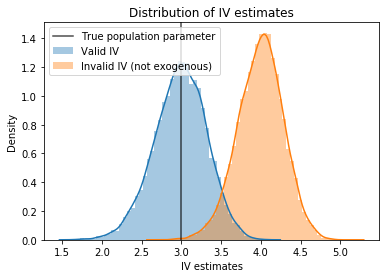

In [16]:
# Plot distributions

plt.clf()

sns.distplot(iv_valid, hist=True, kde=True, label='Valid IV')
sns.distplot(iv_not_exog, hist=True, kde=True, label="Invalid IV (not exogenous)")
plt.axvline(x=beta_1, color='black', alpha = 0.7, label='True population parameter')
plt.legend()

plt.title("Distribution of IV estimates")
plt.xlabel("IV estimates")
plt.ylabel("Density")

plt.show()

The figure shows the approximate sampling distribution of the valid IV estimator (case 1) and the invalid IV estimator (case 2).

The estimates for the valid IV are centered around the true parameter value, but this is not the case for the invalid IV.

This shows that when the instrument does not satisfy the exogeneity condition, the estimates obtained are biased and inconsistent. This bias can be large (+33% here) even when the correlation between the instrument and the unobserved error term is low.


#### Generalising to different cases

Recall that:

\begin{equation*}
\text{plim } \hat{\theta}_{1, IV} = \beta_1 + \frac{\beta_2 Cov (z, ability)}{Cov(z, education)} 
\end{equation*}

Thus, the bias of the IV estimator depends on $\beta_2$, $Cov(z, ability)$ and $Cov(z, education)$. In this subsection, I look at the impact of the sign of these values on the direction of the inconsistency.

In [17]:
# Generating the data frame with all the combinations of signs of beta_2, Cov(z, abil) and Cov(z, educ)

a = 0.1 # cov_z_abil used in case 2
b = 0.5 # cov_z_educ used in case 2

dict_columns = {'beta_2': np.concatenate( (np.full(4, beta_2), np.full(4, -beta_2)), axis=None),
               'cov_z_abil': np.tile([a, -a], 4),
               'cov_z_educ': np.tile([b, b, -b, -b], 2)}

df = pd.DataFrame.from_dict(dict_columns)

print(df)

   beta_2  cov_z_abil  cov_z_educ
0       5         0.1         0.5
1       5        -0.1         0.5
2       5         0.1        -0.5
3       5        -0.1        -0.5
4      -5         0.1         0.5
5      -5        -0.1         0.5
6      -5         0.1        -0.5
7      -5        -0.1        -0.5


After having created a data frame containing different possible values for $\beta_2$, $Cov(z, education)$ and $Cov(z, ability)$, I run the simulations and report the mean IV estimates.

I also compute the theoretical mean IV estimates using the formula above.

In [18]:
beta_iv = []

for i in range(0, 8):

    beta_2 = df.iloc[i]['beta_2']
    cov_z_abil = df.iloc[i]['cov_z_abil']
    cov_z_educ = df.iloc[i]['cov_z_educ']

    N = 1000
    B = 1000 # Reduce the number of simulations to save time

    mean = [0, 0, 0, 0]

    cov = gen_cov_matrix(cov_z_abil = cov_z_abil,
                            cov_z_educ = cov_z_educ,
                            cov_educ_abil = 0.7)

    output = run_simulations(mean, cov, N, B, "iv")

    beta_iv.append(np.mean(output))

df.insert(loc=3, column='beta_iv_simulations', value=beta_iv)

df['beta_iv_theory'] = beta_1 + df['beta_2'] * df['cov_z_abil'] / df['cov_z_educ']

print(df)

# Reset beta_2 to 5

beta_2 = 5

   beta_2  cov_z_abil  cov_z_educ  beta_iv_simulations  beta_iv_theory
0       5         0.1         0.5             3.988731             4.0
1       5        -0.1         0.5             1.979841             2.0
2       5         0.1        -0.5             1.967736             2.0
3       5        -0.1        -0.5             4.007271             4.0
4      -5         0.1         0.5             2.010549             2.0
5      -5        -0.1         0.5             4.017757             4.0
6      -5         0.1        -0.5             4.030163             4.0
7      -5        -0.1        -0.5             1.992902             2.0


The table shows that the simulations confirm the theory, as the estimated coefficients are very close to the theoretical ones.

Moreover, it illustrates that the IV estimator can be biased upwards ($E(\hat{\beta}_{IV}) > 3$) or downwards ($E(\hat{\beta}_{IV}) < 3$), depending on $\beta_2$, $Cov(z, education)$ and $Cov(z, ability)$. 

Finally, in the next cell, I create a summary table covering the different possibilities. 

In [19]:
# Sign of the bias - summary table

df['bias'] = df['beta_iv_simulations'] - beta_1

def get_sign(x):
    if x > 0:
        return "+"
    elif x < 0:
        return "-"
    elif x == 0:
        return "0"
    
df = df.applymap(get_sign)

df = df.drop('beta_iv_simulations', axis=1)
df = df.drop('beta_iv_theory', axis=1)

print(df)

  beta_2 cov_z_abil cov_z_educ bias
0      +          +          +    +
1      +          -          +    -
2      +          +          -    -
3      +          -          -    +
4      -          +          +    -
5      -          -          +    +
6      -          +          -    +
7      -          -          -    -


The table above shows that when $\beta_2 > 0$, $Cov(z, ability) > 0$ and $Cov(z, education) > 0$, the IV estimates will be biased upwards. Alternatively, if $\beta_2$ and $Cov(z, ability)$ stay the same, but $Cov(z, education < 0)$, then the IV estimates will be biased downwards.

Recall that the sign of the correlation between two variables and their covariance is the same, and the sign of $\beta_2$ is the same as $Corr(wage, ability)$. Therefore, we can conclude that when exogeneity fails, the direction of the bias of the IV estimator depends on the sign of: 
1. the correlation between the dependent and the omitted variable (same sign as $\beta_2$), 
2. the correlation between the instrument and the endogenous variable (same sign as $Cov(z, education)$), and 
3. the correlation between the instrument and the omitted variable (same sign as $Cov(z, ability)$).

Thus, the direction of the bias might be predicted. 
An implication is that the IV estimates can provide an upper or lower bound for the parameter of interest. For example, going back to our initial scenario with $\beta_2 = 5$ and $Cov(z, education) = 0.5$, if we suspect that the instrument is positively correlated with the omitted variable ($Cov(z, ability) = 0.1 > 0$), then we know that the IV estimate will be biased upwards. 
Thus, we can expect that the actual population parameter is lower than the IV estimate, which can be a valuable information.

## Case 3: Relevance fails

Now, let us turn to the situation in which the exogeneity condition is satisfied, but the relevance condition is violated. That is, we have $Cov(z, education) = 0$. 

I keep $Cov(z, ability)=0$ (the exogeneity condition is satisfied) and $Cov(education, ability) = 0.7$ (simple OLS regression would have an omitted variable bias).

The covariance matrix becomes

\begin{equation*}
\mathbf{\Omega} =  \begin{bmatrix}
1 & 0.7 & \boldsymbol{0} & 0 \\
0.7 & 1 & 0 & 0 \\
\boldsymbol{0} & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

where the values in bold are the ones that have changed compared to the first case.

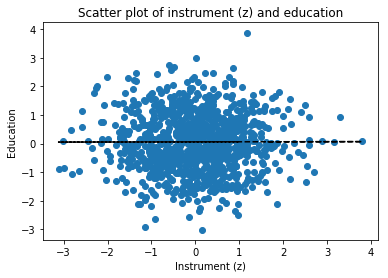

In [20]:
# Set the parameters

mean = [0, 0, 0, 0]

cov_weak = gen_cov_matrix(cov_z_abil = 0, # Exogeneity satisfied
                        cov_z_educ= 0, # Relevance violated
                        cov_educ_abil = 0.7)

N = 1000 

# Generate the data

np.random.seed(0)
gen_data(mean, cov_weak, N)

# Relationship between z and educ: weak instrument

plt.clf()
plt.scatter(z, educ)
plt.title("Scatter plot of instrument (z) and education")
plt.xlabel("Instrument (z)")
plt.ylabel("Education")

trend_line = np.polyfit(z, educ, 1)
p = np.poly1d(trend_line)
plt.plot(z,p(z),"k--")

plt.show()

As we can see on the diagram, the regression line is horizontal, confirming that $Cov(z, education) = 0$.

In the next cell, I run the Monte Carlo simulations by drawing 10,000 samples.

In [21]:
# Run the simulations

B = 10000 # Number of simulations
N = 1000 # Number of observations

iv_weak, ols_weak = run_simulations(mean, cov_weak, N, B, "iv and ols")

print("Mean of IV estimates:", round(np.mean(iv_weak), 2))
mean_iv = np.mean(iv_weak)
print("Median of IV estimates:", round(np.median(iv_weak), 2))
print("Mean of OLS estimates:", round(np.mean(ols_weak), 2))
print("Median of OLS estimates:", round(np.median(ols_weak), 2))
print("True population parameter:", beta_1)

Mean of IV estimates: 5.39
Median of IV estimates: 6.6
Mean of OLS estimates: 6.5
Median of OLS estimates: 6.5
True population parameter: 3


The mean of the IV estimates is 5.39, which is between the true population parameter 3 and the mean of the OLS estimates 6.50. 

This is what theory predicts: [Angrist and Pischke (2009)](http://econ.lse.ac.uk/staff/spischke/mhe/josh/solon_justid_April14.pdf) show that with a really low first stage coefficient (less than 0.1), the just-identified IV estimator is biased. As the first stage coefficient approaches zero, the median of the estimator approaches that of OLS, which is also what I find here.

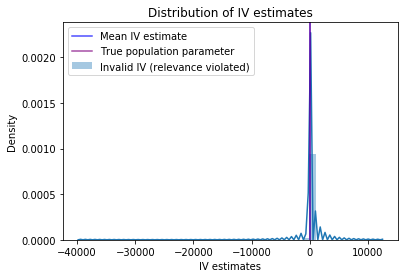

Standard deviation of IV estimates: 433.6


In [22]:
plt.clf()

sns.distplot(iv_weak, hist=True, kde=True, label="Invalid IV (relevance violated)")
plt.axvline(x=mean_iv, color='blue', alpha = 0.7, label='Mean IV estimate')
plt.axvline(x=beta_1, color='purple', alpha = 0.7, label='True population parameter')

plt.legend()

plt.title("Distribution of IV estimates")
plt.xlabel("IV estimates")
plt.ylabel("Density")

plt.show()

print("Standard deviation of IV estimates:", round(np.std(iv_weak), 2))

The cell above plots the distribution of the IV estimates obtained with the Monte Carlo simulations.

We can see that the estimates are highly unstable and imprecise, which confirms the theoretical prediction.

Although the point estimates are biased, the confidence intervals are likely to be so large that they will contain the true population value. If we look not only at the point estimate but at the confidence region, then [Angrist and Pischke (2009)](http://econ.lse.ac.uk/staff/spischke/mhe/josh/solon_justid_April14.pdf) argue that just-identified IV with a weak instrument is "unlikely to lead researchers astray in actual applications".

# Discussion and conclusion

This project has shown using Monte Carlo simulations that IV estimates can be biased and inconsistent when the assumptions of instrument exogeneity and relevance are violated.

When exogeneity is violated, in the simple case with only one endogenous variable and one instrument, the IV estimator will be biased upwards if $\beta_2>0$, $Cov(z, education) >0$ and $Cov(z, ability>0)$.

When the relevance condition is violated, the IV estimator is biased towards OLS, and the estimates are highly unstable and imprecise.

This project focused on a very simple case, with one endogenous variable and one instrument only, and assumed homogeneous treatment effects. Future work could look at more complex situations, with many instruments and/or heterogeneous treatment effects. 

[↑ Back to top](#Python-assignment:-Bias-of-invalid-IV-estimates)